# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [34]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/nilsw/Lab1ID2223
HopsworksSettings initialized!


In [35]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [36]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 14, 14, 1, 58, 739909)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [37]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-14 14:01:58,746 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-14 14:01:58,751 INFO: Initializing external client
2025-11-14 14:01:58,752 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-14 14:01:59,373 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-14 14:02:00,298 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [38]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_v_cgrade",
    version=1,
)

fv = retrieved_model.get_feature_view()


# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()


2025-11-14 14:02:05,140 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/537785 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/109786 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26752 elapsed<00:00 remaining<?

In [39]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.234511E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [40]:
weather_fg = fs.get_feature_group(
    name='weather_v_cgrade',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read() #change back
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,6.30,0.0,8.891344,338.629303,saitama-ken
1,2025-11-15 00:00:00+00:00,9.00,0.0,4.198285,120.963692,saitama-ken
2,2025-11-16 00:00:00+00:00,11.25,0.0,1.835647,101.309898,saitama-ken
3,2025-11-20 00:00:00+00:00,7.40,0.0,2.902413,29.744795,saitama-ken
4,2025-11-17 00:00:00+00:00,11.65,0.0,6.763786,334.798920,saitama-ken
5,2025-11-19 00:00:00+00:00,6.90,0.0,6.877790,83.991089,saitama-ken


In [41]:
# NEW. ADDS ROLLING MEAN FOR FIRST DAY AND 0 VALUE IN ALL COLUMN FOR ROLL
"""import pytz

adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)

air_quality_group = fs.get_feature_group(name='air_quality', version=1)
first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
print(first_init_roll)
batch_data["roll"] = pd.Series(0, index=batch_data.index).astype("float64")
batch_data.loc[batch_data["date"] == adj_tomorrow, "roll"] = first_init_roll["pm25"].mean()
#batch_data"""

import pytz

adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
adj_2day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=2)).replace(hour=0, minute=0, second=0, microsecond=0)
adj_3day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=3)).replace(hour=0, minute=0, second=0, microsecond=0)

air_quality_group = fs.get_feature_group(name='air_quality_v_cgrade', version=1)
first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
print(first_init_roll)
pm_series = first_init_roll.sort_values('date')['pm25'].tail(3)

rolling3 = pm_series.mean()
lag1 = pm_series.iloc[-1]
lag2 = pm_series.iloc[-2]
lag3 = pm_series.iloc[-3]

m1 = batch_data['date'] == adj_tomorrow
m2 = batch_data['date'] == adj_2day
m3 = batch_data['date'] == adj_3day

batch_data.loc[m1, 'rolling3'] = rolling3
batch_data.loc[m1, ['lag1d', 'lag2d', 'lag3d']] = [lag1, lag2, lag3]

batch_data.loc[m2, ['lag2d', 'lag3d']] = [lag1, lag2]

batch_data.loc[m3, ['lag3d']] = lag1

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 
                       date  pm25   rolling3  lag1d  lag2d  lag3d country  \
0 2025-11-12 00:00:00+00:00  19.0  30.666666   14.0   30.0   48.0   Japan   
1 2025-11-13 00:00:00+00:00  57.0  21.000000   19.0   14.0   30.0   Japan   
2 2025-11-14 00:00:00+00:00  63.0  30.000000   57.0   19.0   14.0   Japan   

          city     street                               url  
0  saitama-ken  gakuendai  https://api.waqi.info/feed/@9937  
1  saitama-ken  gakuendai  https://api.waqi.info/feed/@9937  
2  saitama-ken  gakuendai  https://api.waqi.info/feed/@9937  


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling3,lag1d,lag2d,lag3d
0,2025-11-18 00:00:00+00:00,6.30,0.0,8.891344,338.629303,saitama-ken,NaN,NaN,NaN,NaN
1,2025-11-15 00:00:00+00:00,9.00,0.0,4.198285,120.963692,saitama-ken,46.333332,63.0,57.0,19.0
2,2025-11-16 00:00:00+00:00,11.25,0.0,1.835647,101.309898,saitama-ken,NaN,NaN,63.0,57.0
3,2025-11-20 00:00:00+00:00,7.40,0.0,2.902413,29.744795,saitama-ken,NaN,NaN,NaN,NaN
4,2025-11-17 00:00:00+00:00,11.65,0.0,6.763786,334.798920,saitama-ken,NaN,NaN,NaN,63.0
5,2025-11-19 00:00:00+00:00,6.90,0.0,6.877790,83.991089,saitama-ken,NaN,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [42]:
# OLD SOLUTION IGNORING ROLLING MEAN
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

###########################
"""
old loop logic
predicted_pm = retrieved_xgboost_model.predict(
        batch_data.loc[batch_data["date"] == time_obj,
    ["roll", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
    batch_data.loc[batch_data["date"] == time_obj, "predicted_pm25"] = predicted_pm
    
    first_init_roll.loc[len(first_init_roll)] = {"date":time_obj, "pm25":predicted_pm[0], "roll":0.0, "country":"Japan", "city":"saitama-ken", "street":"gakuendai", "url":"https://api.waqi.info/feed/@9937"}
    time_obj += datetime.timedelta(days=1)
    batch_data.loc[batch_data["date"] == time_obj, "roll"] = first_init_roll["pm25"].tail(3).mean()

"""
# NEW SOLUTION WITH ROLLING MEAN

time_obj = adj_tomorrow

for _ in range(len(batch_data)):

    mask = batch_data["date"] == time_obj
    
    X = batch_data.loc[mask,["rolling3", "lag1d", "lag2d", "lag3d", 
                             "temperature_2m_mean", "precipitation_sum", 
                             "wind_speed_10m_max", "wind_direction_10m_dominant"]]

    y_pred = retrieved_xgboost_model.predict(X)[0]
    batch_data.loc[mask, "predicted_pm25"] = y_pred

    new_data = {
        "date": time_obj,
        "pm25": y_pred,
        "country": "Japan",
        "city": "saitama-ken",
        "street": "gakuendai",
        "url": "https://api.waqi.info/feed/@9937",
    }

    first_init_roll = pd.concat([first_init_roll, pd.DataFrame([new_data])], ignore_index=True)

    time_next = time_obj + datetime.timedelta(days=1)

    if(batch_data["date"]== time_next).any():
        recent = first_init_roll.sort_values("date")["pm25"].tail(3)

        rolling3 = recent.mean()
        lag1 = recent.iloc[-1]
        lag2 = recent.iloc[-2]
        lag3 = recent.iloc[-3]

        mask_next = batch_data["date"] == time_next
        batch_data.loc[mask_next, ["rolling3", "lag1d", "lag2d", "lag3d"]] = [rolling3,lag1,lag2,lag3]

    time_obj = time_next
    
        



batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling3,lag1d,lag2d,lag3d,predicted_pm25
0,2025-11-18 00:00:00+00:00,6.30,0.0,8.891344,338.629303,saitama-ken,60.473324,68.944916,52.251839,60.223217,84.525986
1,2025-11-15 00:00:00+00:00,9.00,0.0,4.198285,120.963692,saitama-ken,46.333332,63.000000,57.000000,19.000000,60.223217
2,2025-11-16 00:00:00+00:00,11.25,0.0,1.835647,101.309898,saitama-ken,60.074406,60.223217,63.000000,57.000000,52.251839
3,2025-11-20 00:00:00+00:00,7.40,0.0,2.902413,29.744795,saitama-ken,79.084808,83.783531,84.525986,68.944916,68.589645
4,2025-11-17 00:00:00+00:00,11.65,0.0,6.763786,334.798920,saitama-ken,58.491688,52.251839,60.223217,63.000000,68.944916
5,2025-11-19 00:00:00+00:00,6.90,0.0,6.877790,83.991089,saitama-ken,68.574249,84.525986,68.944916,52.251839,83.783531


In [43]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling3                     6 non-null      float32                
 7   lag1d                        6 non-null      float32                
 8   lag2d                        6 non-null      float32                
 9   lag3d                        6 non-null      float32                
 10  predic

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [44]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling3,lag1d,lag2d,lag3d,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-15 00:00:00+00:00,9.00,0.0,4.198285,120.963692,saitama-ken,46.333332,63.000000,57.000000,19.000000,60.223217,gakuendai,Japan,1
2,2025-11-16 00:00:00+00:00,11.25,0.0,1.835647,101.309898,saitama-ken,60.074406,60.223217,63.000000,57.000000,52.251839,gakuendai,Japan,2
4,2025-11-17 00:00:00+00:00,11.65,0.0,6.763786,334.798920,saitama-ken,58.491688,52.251839,60.223217,63.000000,68.944916,gakuendai,Japan,3
0,2025-11-18 00:00:00+00:00,6.30,0.0,8.891344,338.629303,saitama-ken,60.473324,68.944916,52.251839,60.223217,84.525986,gakuendai,Japan,4
5,2025-11-19 00:00:00+00:00,6.90,0.0,6.877790,83.991089,saitama-ken,68.574249,84.525986,68.944916,52.251839,83.783531,gakuendai,Japan,5
3,2025-11-20 00:00:00+00:00,7.40,0.0,2.902413,29.744795,saitama-ken,79.084808,83.783531,84.525986,68.944916,68.589645,gakuendai,Japan,6


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [45]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 3
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling3                     6 non-null      float32                
 7   lag1d                        6 non-null      float32                
 8   lag2d                        6 non-null      float32                
 9   lag3d                        6 non-null      float32                
 10  predicted_p

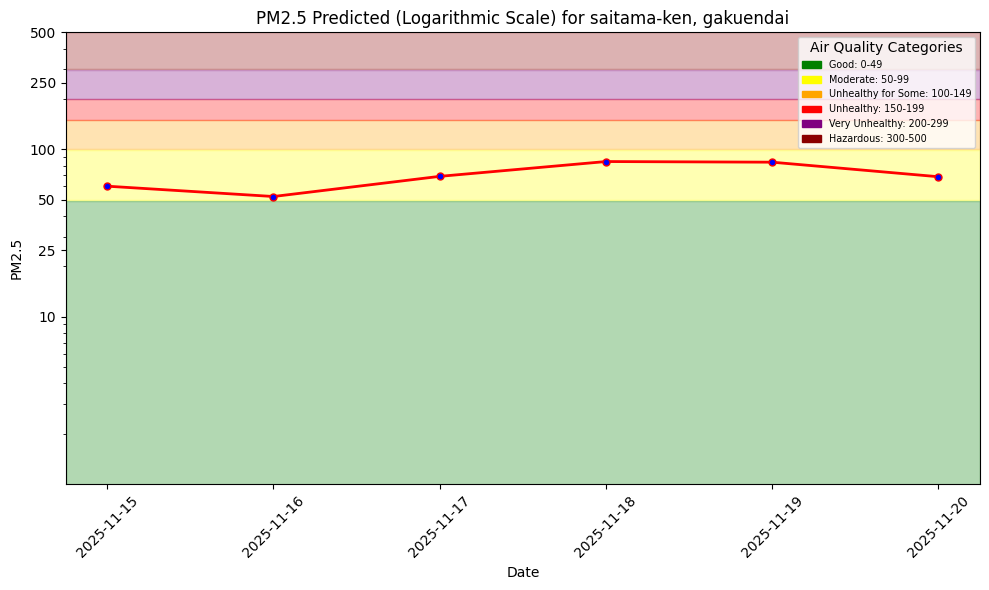

In [46]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [47]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_v_cgrade',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [48]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_cgrade_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286328/jobs/named/aq_predictions_v_cgrade_1_offline_fg_materialization/executions
2025-11-14 14:02:32,156 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-14 14:02:35,362 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 14:03:58,660 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 14:03:58,840 INFO: Waiting for log aggregation to finish.
2025-11-14 14:04:07,540 INFO: Execution finished successfully.


(Job('aq_predictions_v_cgrade_1_offline_fg_materialization', 'SPARK'), None)

In [49]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling3,lag1d,lag2d,lag3d,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,12.5,0.1,0.360000,270.000000,saitama-ken,30.000000,57.0,19.0,14.0,66.285988,gakuendai,Japan,1
1,2025-11-15 00:00:00+00:00,9.0,0.0,4.198285,120.963692,saitama-ken,46.333332,63.0,57.0,19.0,60.223217,gakuendai,Japan,1


In [50]:
air_quality_fg = fs.get_feature_group(name='air_quality_v_cgrade', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,pm25,rolling3,lag1d,lag2d,lag3d,country,city,street,url
0,2018-06-12 00:00:00+00:00,39.0,39.666668,13.0,41.0,65.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
1,2021-03-16 00:00:00+00:00,60.0,28.333334,36.0,18.0,31.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
2,2021-05-30 00:00:00+00:00,45.0,43.333332,54.0,41.0,35.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
3,2021-11-03 00:00:00+00:00,50.0,61.333332,59.0,56.0,69.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
4,2017-10-30 00:00:00+00:00,21.0,56.666668,30.0,78.0,62.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
...,...,...,...,...,...,...,...,...,...,...
2995,2018-05-05 00:00:00+00:00,55.0,50.333332,34.0,40.0,77.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
2996,2016-08-30 00:00:00+00:00,19.0,27.666666,18.0,35.0,30.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
2997,2017-09-29 00:00:00+00:00,34.0,45.333332,27.0,50.0,59.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937
2998,2025-11-13 00:00:00+00:00,57.0,21.000000,19.0,14.0,30.0,Japan,saitama-ken,gakuendai,https://api.waqi.info/feed/@9937


In [51]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
print(len(hindcast_df))
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    # we need to predict with our model since its C version
    
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)

    X = pd.concat([
    batch_data.sort_values(by=['date'], ascending=True)[["date","roll"]].reset_index(drop=True),
    features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].reset_index(drop=True)
    ], axis=1)
    
    X['predicted_pm25'] = retrieved_xgboost_model.predict(X[["roll","temperature_2m_mean","precipitation_sum","wind_speed_10m_max","wind_direction_10m_dominant"]])
    df = pd.merge(X, air_quality_df[['date','pm25','street','country',"city"]], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    df = df.drop('pm25', axis=1)
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    
hindcast_df

1


,date,predicted_pm25,pm25
0,2025-11-14 00:00:00+00:00,66.285988,63.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

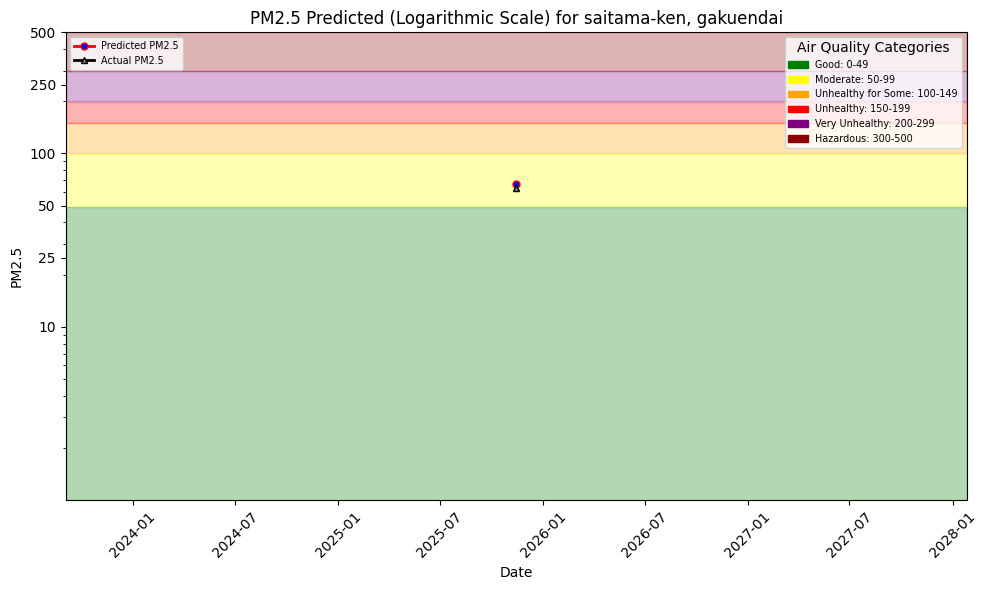

In [52]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [54]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality_v_cgrade") == False:
    dataset_api.mkdir("Resources/airquality_v_cgrade")
dataset_api.upload(pred_file_path, f"Resources/airquality_v_cgrade/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality_v_cgrade/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v_cgrade")

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | 0/42642 ela…

Uploading /home/nilsw/Lab1ID2223/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|          | 0/4328…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286328/settings/fb/path/Resources/airquality_v_cgrade


---